Давайте потестируем производительность БД Redis, которая относится к базам "ключ-значение".

Документация на обертку для Питона находится [здесь](https://redis-py.readthedocs.io/en/stable/genindex.html).

Установим саму базу данных и redis-py (`pip install redis`). Помимо этого установим библиотеку hiredis (`pip install hiredis`), которая обрабатывает ответ от БД несколько быстрее.

Воспользуемся тем, что Mongo и bson у нас уже установлены<sup>\*</sup>. Будем генерировать уникальные идентификаторы при помощи ObjectId.
<hr>
<sup>*</sup> По-крайней мере, у меня. Если кто-либо хочет синхронизироваться, пусть поставит библиотеку для работы с Mongo - <a href="http://api.mongodb.com/python/current/api/index.html">pymongo</a>.

In [1]:
# Импортируем драйвер к Redis.
import redis
from bson import ObjectId
import datetime
import time

Присоединяемся к базе данных. По умолчанию она работает только с локальной машиной, аутентификация не предусмотрена.

На самом деле, параметры можно не указывать, ниже передаются те же самые значения, что принимаются по умолчанию.

In [2]:
r = redis.Redis(host='localhost', port=6379, db=0)

Попробуем положить какой-нибудь ключ...

In [3]:
r.set('foo', 'bar')

True

... и получить его обратно.

In [4]:
r.get('foo')

b'bar'

In [5]:
ttt = r.get('foo')

In [9]:
ttt.decode()

'bar'

In [11]:
r.set('foo', 100)
int(r.get('foo'))

100

ObjectId по умолчанию генерирует некоторый уникальный ключ. В дальнейшем мы будем преобразовывать его к строке и использовать как уникальный ключ для наших данных.

In [14]:
ObjectId()

ObjectId('5fb6a8eca99faadc798c62e4')

При помощи функции `keys` можно посмотреть все ключи в базе. Функция `flushdb` очищает текущую базу.

In [17]:
r.keys()

[]

In [5]:
r.flushdb()

True

Померим скорость работы с базой при помощи такого простого метода, как `set`. Положим в базу 100 000 уникальных ключей, к которым привязано одно целое число.

In [18]:
%%time
for i in range(100000):
    r.set(str(ObjectId()), i)
#    r.set(i, i)


CPU times: user 6.2 s, sys: 1.63 s, total: 7.84 s
Wall time: 9.84 s


Примерно 20 000 операций вставки в секунду на локальной машине. Не так уж и много.

Посмотрим с какой скоростью они будут читаться.

In [19]:
%%time
summ=0
for k in r.keys():
    summ+=int(r.get(k))

print("Всего ключей:", len(r.keys()))

Всего ключей: 100000
CPU times: user 4.24 s, sys: 1.83 s, total: 6.07 s
Wall time: 7.97 s


Около 20 000 операций чтения.

Хм... Этот Redis, кажется, не такой уж и молодец.

Или мы что-то делаем не так? Давайте сравним с `dict`.

In [20]:
%%time
tst_dct={}
for i in range(100000):
    tst_dct[str(ObjectId())]=i

CPU times: user 446 ms, sys: 33.9 ms, total: 480 ms
Wall time: 481 ms


Примерно 300 000 операций записи в секунду...

In [21]:
%%time
summ=0
for k in tst_dct.keys():
    summ+=int(tst_dct[k])

CPU times: user 73.4 ms, sys: 8.08 ms, total: 81.5 ms
Wall time: 80.7 ms


... и примерно 2,5 млн операций чтения в секунду. Пока Redis очень далеко до `dict`.

Хотя dict не умеет отдавать данные нескольким программам одновременно.

Давайте пока посмотрим что Redis  умеет еще. Например, при помощи функции `expire` каждой паре можно сказать, что она утрачивает актуальность через какое-то время. 

Положим в базу 100 000 ключей, каждому из них установим время жизни 10 секунд, уснём на 15 секунд и посмотрим что осталось в базе.

In [22]:
r.flushdb()

for i in range(100000):
    oid=str(ObjectId())
    r.set(oid, i)
    r.expire(oid, 10)

time.sleep(15)

summ=0
for k in r.keys():
    summ+=int(r.get(k))
    
print(r.dbsize(), summ)

0 0


In [25]:
print(r.get(oid))

None


Как видно, не осталось ничего. Метод работает.

Помимо работы с простыми числами, Redis позволяет организовывать список, привязанный к определенному ключу. При помощи функций `rpush` и `lpush` можно класть значения в очередь с заданным ключем.

In [26]:
%%time
for i in range(100000):
    r.lpush('firstkey', i)
    r.lpush('secondkey', i)
    
print(r.keys())

[b'secondkey', b'firstkey']
CPU times: user 8.35 s, sys: 3.04 s, total: 11.4 s
Wall time: 14.7 s


In [27]:
r.flushdb()

True

In [28]:
%%time
for i in range(100000):
    r.rpush('firstkey', i)
    r.rpush('secondkey', i)
    
print(r.keys())

[b'secondkey', b'firstkey']
CPU times: user 8.66 s, sys: 3.06 s, total: 11.7 s
Wall time: 15 s


Получается еще медленнее, чем при помощи `set`.

Извлекаем данные при помощи `lpop` и `rpop`. Как видно, получается тоже не быстро.

In [29]:
%%time
for i in range(100000):
    r.lpop('firstkey')
    r.lpop('secondkey')

CPU times: user 7.79 s, sys: 3.13 s, total: 10.9 s
Wall time: 14.3 s


Теперь попробуем пакетную запись значений. 

Может быть генерация ключей занимает больше времени, чем работа с БД? Отдельно сгенерируем идентификаторы для ключей, а потом положим их в базу.

In [30]:
%%time
objs=[str(ObjectId()) for i in range(100000)]

CPU times: user 416 ms, sys: 16.4 ms, total: 432 ms
Wall time: 433 ms


In [31]:
%%time
for i,x in enumerate(objs):
    r.set(x, i)

CPU times: user 4.69 s, sys: 1.72 s, total: 6.41 s
Wall time: 8.18 s


Быстрее не вышло. Может быть дело в for, и с помощью map мы сделаем всё быстрее?

In [32]:
%%time
_=list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))

CPU times: user 4.76 s, sys: 1.52 s, total: 6.27 s
Wall time: 7.95 s


Убедимся, что мы не забыли сгенерировать новые ключи перед запуском предыдущей ячейки - проверим количество ключей в базу.

In [33]:
r.dbsize()

100000

Также убедимся, что работа со словарем всё еще быстрее. Кстати, значительно быстрее генерации ключей.

In [34]:
%%time
tst_dct={}
for i in enumerate(objs):
    tst_dct[x]=i

CPU times: user 36.1 ms, sys: 0 ns, total: 36.1 ms
Wall time: 36 ms


Ключи в самом деле лежат в базе?

In [35]:
list(r.keys())[:10]

[b'5fb6ac07a99faadc79926517',
 b'5fb6ac07a99faadc799140b3',
 b'5fb6ac07a99faadc799108d7',
 b'5fb6ac07a99faadc799149d0',
 b'5fb6ac07a99faadc7991e1ff',
 b'5fb6ac07a99faadc79924985',
 b'5fb6ac07a99faadc79923a1b',
 b'5fb6ac07a99faadc799149a7',
 b'5fb6ac07a99faadc79913d29',
 b'5fb6ac07a99faadc799195ec']

Попробуем функцию mset, которая кладет всё содержимое словаря одновременно.

In [36]:
%%time
objs={str(ObjectId()):i for i in range(100000)}
r.mset(objs)

CPU times: user 910 ms, sys: 48 ms, total: 958 ms
Wall time: 1.09 s


True

In [37]:
mkeys = list(r.keys())[:1000]

In [38]:
%%time
_ = r.mget(mkeys)

CPU times: user 2.58 ms, sys: 866 µs, total: 3.44 ms
Wall time: 4.65 ms


Получается в несколько раз быстрее - около 130 000 ключей в секунду. Но это всё еще не похоже на миллион запросов в секунду.

Хорошо, может быть это Питон не справляется, а база может работать быстрее? Попробуем запустить несколько потоков, которые пишут в базу. Оформим генерацию ключей и загрузку ключей в базу как отдельную функцию, чтобы можно было ее запускать в параллельных потоках.

In [6]:
import multiprocessing

In [40]:
def putKey2Redis():
    objs={str(ObjectId()):i for i in range(100000)}
    #_=list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))
    r.mset(objs)

In [41]:
%%time
pr=[]

for i in range(10):
    p=multiprocessing.Process(target=putKey2Redis)
    p.start()
    pr.append(p)

for p in pr:
    p.join()

CPU times: user 23.9 ms, sys: 18.9 ms, total: 42.8 ms
Wall time: 3.21 s


330 000 запросов в секунду. Явно улучшение не в 10 раз. Значит дело не только в Питоне. Но скорость уже впечатляющая. От обычной БД с настройками из коробки такую скорость не получишь.

Redis умеет привязывать к ключу хешированный массив - аналог питоновского словаря. Попробуем класть его при помощи функции `hmset` (h - хешированный. m - много ключей сразу).

In [42]:
r.flushdb()

True

In [43]:
def putKey2Redis2(my_key):
    objs={str(ObjectId()):i for i in range(100000)}
    print(my_key, list(objs.keys())[:2])
    r.hmset(my_key, objs)

In [44]:
%%time
pr=[]

for i in range(10):
    p=multiprocessing.Process(target=putKey2Redis2, args=['hash_key'+str(i)])
    p.start()
    pr.append(p)

for p in pr:
    p.join()

hash_key2 ['5fb6b0f2d9ac4f1c17940405', '5fb6b0f2d9ac4f1c17940406']
hash_key3 ['5fb6b0f26e575211c6940405', '5fb6b0f26e575211c6940406']
hash_key7 ['5fb6b0f2681690e998940405', '5fb6b0f2681690e998940406']
hash_key8 ['5fb6b0f2c7e3443646940405', '5fb6b0f2c7e3443646940406']
hash_key6 ['5fb6b0f251e4b07de2940405', '5fb6b0f251e4b07de2940406']
hash_key4 ['5fb6b0f24bc3ae3186940405', '5fb6b0f24bc3ae3186940406']
hash_key0 ['5fb6b0f2728beefd58940405', '5fb6b0f2728beefd58940406']
hash_key9 ['5fb6b0f281cc163114940405', '5fb6b0f281cc163114940406']
hash_key1 ['5fb6b0f29a1f97489b940405', '5fb6b0f29a1f97489b940406']
hash_key5 ['5fb6b0f2b37c5483b6940405', '5fb6b0f2b37c5483b6940406']
CPU times: user 16.6 ms, sys: 39.7 ms, total: 56.3 ms
Wall time: 3.35 s


In [45]:
r.keys()

[b'hash_key4',
 b'hash_key6',
 b'hash_key9',
 b'hash_key7',
 b'hash_key1',
 b'hash_key0',
 b'hash_key8',
 b'hash_key3',
 b'hash_key5',
 b'hash_key2']

In [50]:
r.hget('hash_key3', '5fb6b0f26e575211c6940406')

b'1'

In [52]:
r.hmset("test_key", {"c":3})

True

In [53]:
r.hmset("test_key", {"a":1, "b":2})

True

In [54]:
r.hget("test_key", "c")

b'3'

In [55]:
r.hmset("test_key", {"c":"{'s':'d'}"})

True

In [56]:
r.hget("test_key", "c")

b"{'s':'d'}"

In [61]:
r.hmget("test_key",['a','c'])

[b'1', b"{'s':'d'}"]

Увеличения скорости не наблюдается.

При помощи функции `hkeys` можно получить ключи для конкретного хеш-массива. `hmget` позволяет получить значения по нескольким ключам.

In [65]:
r.flushdb()

True

In [66]:
%%time
objs={str(ObjectId()):i for i in range(100000)}

CPU times: user 351 ms, sys: 34.8 ms, total: 386 ms
Wall time: 385 ms


In [67]:
%%time
r.hmset("longkey", objs)

CPU times: user 474 ms, sys: 8.64 ms, total: 483 ms
Wall time: 602 ms


True

In [69]:
ho=r.hkeys("longkey")

In [70]:
ho[:10]

[b'5f96a09a746fb4df4704f017',
 b'5f96a09a746fb4df4704996e',
 b'5f96a09a746fb4df4704f6f2',
 b'5f96a09a746fb4df4704ef8a',
 b'5f96a09a746fb4df470512ff',
 b'5f96a09a746fb4df47053293',
 b'5f96a09a746fb4df4703c936',
 b'5f96a09a746fb4df4703de5b',
 b'5f96a09a746fb4df4704b83d',
 b'5f96a09a746fb4df4704fb72']

In [74]:
%%time
oo=r.hmget("longkey", ho[:10])

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 1.17 ms


In [76]:
oo

[b'81071',
 b'58886',
 b'82826',
 b'80930',
 b'90007',
 b'98091',
 b'5582',
 b'10995',
 b'66773',
 b'83978']

In [78]:
%%time
for k in ho:
    _=r.hget("longkey", k)

CPU times: user 3.87 s, sys: 1.45 s, total: 5.32 s
Wall time: 6.82 s


Redis поддерживает блокирующие операции. При помощи `brpop` и `blpop` мы можем приостановить свои действия либо пока не будет получено значение, либо пока не пройдет заданный промежуток времени.

Если функция успешно получила значение, она вернет его после ожидания.

In [79]:
r.rpush("blockedTest", "asdf")
print(r.brpop("blockedTest", 1))

(b'blockedTest', b'asdf')


Если значение не было получено за время ожидания, возвращается None.

In [7]:
def blockingWrite():
    time.sleep(5)
    r.lpush("blockedTest", "Yahooo!")
    
def blockingRead():
    bres=r.brpop("blockedTest", 1)
    while bres==None:
        print("waiting")
        bres=r.brpop("blockedTest", 1)
    print(bres)
    
bpr1=multiprocessing.Process(target=blockingWrite)
bpr2=multiprocessing.Process(target=blockingRead)
bpr1.start()
bpr2.start()
bpr1.join()
bpr2.join()

waiting
waiting
waiting
waiting
(b'blockedTest', b'Yahooo!')


Помимо этого, к ключу можно привязать множество. Добавление в множество ведется при помощи операции `sadd`. Также можно находить пересечение (`sinter`), объединение (`sunion`)  разницу (`sdiff`) множеств.

In [8]:
r.sadd("testSets1", "A")
r.sadd("testSets1", "B")
r.sadd("testSets1", "C")

r.sadd("testSets2", "A")
r.sadd("testSets2", "D")
r.sadd("testSets2", "F")

r.sinter(["testSets1","testSets2"])


{b'A'}

Результаты пересечения и объединения можно сохранить в другое множество.

In [9]:
r.sunionstore("testSets3", ["testSets1", "testSets2"])
r.smembers("testSets3")

{b'A', b'B', b'C', b'D', b'F'}

Элемент можно атомарно перебросить из одного множества в другое при помощи `smove`.

In [10]:
r.smove("testSets2", "testSets1", 'F')
r.smembers("testSets2"), r.smembers("testSets1")

({b'A', b'D'}, {b'A', b'B', b'C', b'F'})

 Удалить значение можно при помощи `srem`, узнать длину множества - `scard`.

In [11]:
r.srem("testSets1", 'F')
r.scard("testSets1")

3

Каждая команда возвращает объект типа `pipeline`. Данный объект позволяет выполнять транзакции. Для этого необходимо при помощи pipeline выполнить несколько команд (они будут поставлены во внутреннюю очередь), а затем вызвать `execute`. Таким образом поддерживаются транзакции для нескольких команд, не требующих промежуточного чтения результатов.

В итоге вернется список результатов выполнения команд.

In [12]:
pipe=r.pipeline()
pipe.srem("testSets1", 'A')
pipe.sadd("testSets1", 'G')
pipe.smembers("testSets1")
pipe.execute()

[1, 1, {b'B', b'C', b'G'}]

In [86]:
r.pipeline().srem("testSets2", 'A').sadd("testSets1", 'R').smembers("testSets1").execute()

[1, 1, {b'B', b'C', b'G', b'R'}]

Если в промежутках необходимо модифицировать какие-то значения, следует использовать следующую конструкцию. В ней `watch` говорит, что мы будем следить за заданным ключем. Команда `multi` говорит о том, что сейчас будет выполняться несколько операций как транзакция. Если значение, связанное с ключем в `watch` изменилось до начала `execute` (выполнение нескольких операций), то будет вызвано исключение.

In [87]:
ppp=r.pipeline()
ppp.multi()
ppp.set("dummy1", "1")
#ppp.multi()
ppp.set("dummy2", "1")
ppp.execute()

[True, True]

In [88]:
r.get("dummy1")

b'1'

In [52]:
r.set('OUR-SEQUENCE-KEY', 1)
with r.pipeline() as pipe:
    while 1:
        try:
            pipe.watch('OUR-SEQUENCE-KEY')
            current_value = pipe.get('OUR-SEQUENCE-KEY')
            next_value = int(current_value) + 1
            pipe.multi()
            pipe.set('OUR-SEQUENCE-KEY', next_value)
            pipe.execute()
            break
        except redis.WatchError:
            continue
            
r.get('OUR-SEQUENCE-KEY')

b'2'

А еще у Redis замечательные [битовые операции](https://blog.getspool.com/2011/11/29/fast-easy-realtime-metrics-using-redis-bitmaps/) и отсортированные списки.

---

Наличие хеш-массивов фактически позволяет хранить в базе данных объекты/словари/JSON и обращаться к ним при помощи уникальных ключей. Правда, плохо получается хранить в полях таких объектов массивы других объектов. Традиционно для таких задач склеивают последовательность ключей в один, используя в качестве разделителя двоеточие. Таким образом, вместо того, чтобы хранить список объектов, мы храним много уникальных ключей, которые известным образом можно соотнести с объектами.

Попробуем решить следующую задачу.

Есть квадратная карта заданного размера. На карте находятся растения, деревья, травоядные и хищники. Необходимо промоделировать поведение системы, обеспечивая обмен данными между частями модели через Redis. 

In [13]:
import random

In [14]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [15]:
r.flushdb()

True

In [16]:
world={"sizeX":50, "sizeY":50, "iniPred":5, "iniCarn":20, 
       "lifeExpPred":10, "lifeExpPredStd":3, "breedPeriodPred":4, "lifePredMin":50, "lifePredMax":100,  
       "lifeExpCarn":10, "lifeExpCarnStd":3, "breedPeriodCarn":3, "lifeCarnMin":50, "lifeCarnMax":100, 
       "herbCount":10000, "treesCount":500, 
       "lifeExpTree":30, "lifeExpTreeStd":5, "breedPeriodTree":6}

r.hmset("worldDescription", world)

True

У тайлов заводим свойство "количество растений в тайле".

In [17]:
tile={"herbs": 0}
for i in range(world["sizeY"]):
    for j in range(world["sizeX"]):
        r.hmset("tile:"+str(i+1)+":"+str(j+1), tile)

Раскидываем растения по тайлам, увеличивая число растений в выбранном тайле.

In [18]:
for i in range(world["herbCount"]):
    x=random.randint(1, world["sizeX"])
    y=random.randint(1, world["sizeY"])
    r.hincrby("tile:"+str(y)+":"+str(x), "herbs", 1)

In [19]:
for i in range(world["iniCarn"]):
    g=random.randint(0, 1)
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    carn={"x":str(x), "y":str(y), 
          "carn_id":str(ObjectId()), "carn_age":0, "carn_gender": g,
          "carn_life_exp": random.randint(world["lifeExpCarn"]-world["lifeExpCarnStd"], world["lifeExpCarn"]+world["lifeExpCarnStd"]), 
          "carn_hunger":0,
          "carn_life":random.randint(world["lifeCarnMin"], world["lifeCarnMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":carns", carn["carn_id"])
    r.hmset("carn:"+carn["carn_id"], carn)
    r.lpush("carns_id", carn["carn_id"])

In [20]:
for i in range(world["iniPred"]):
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    g=random.randint(0, 1)
    pred={"x":str(x), "y":str(y), 
          "pred_id":str(ObjectId()), "pred_age":0, "pred_gender": g,
          "pred_life_exp": random.randint(world["lifeExpPred"]-world["lifeExpPredStd"], world["lifeExpPred"]+world["lifeExpPredStd"]), 
          "pred_hunger":0,
          "pred_life":random.randint(world["lifePredMin"], world["lifePredMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":preds", pred["pred_id"])
    r.hmset("pred:"+pred["pred_id"], pred)
    r.lpush("preds_id", pred["pred_id"])

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
#plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 8)

In [22]:
def showIt(field, who, c_len, s):
    for i in range(c_len):
        c_id=r.rpoplpush(who+"s_id", who+"s_id").decode()
        cx=int(r.hget(who+":"+c_id, "x"))
        cy=int(r.hget(who+":"+c_id, "y"))
        #print("pred:"+p_id, cx, cy)
        field[cy-1][cx-1]=s

def showField():
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    
    carn_len=r.llen("carns_id")
    pred_len=r.llen("preds_id")
    field=[[0 for j in range(sx)] for i in range(sy)]
    for i in range(sy):
        for j in range(sx):
            try:
                field[i][j]=int(r.hget("tile:"+str(i+1)+":"+str(j+1),"herbs"))
            except Exception:
                print("Except:", i, j, r.hget("tile:"+str(i+1)+":"+str(j+1),"herbs"))
    
    """for i in range(sx):
        for j in range(sy):
            herb_cnt=r.hget("tile:"+str(i+1)+":"+str(j+1), "herbs")
            field[i][j]=herb_cnt.decode()""";
    
    showIt(field, "pred", pred_len, 10)
    showIt(field, "carn", carn_len, 12)

    ax = plt.subplot()
    ax.imshow(field);

        
def moveIt(who, c_id, sx, sy):
    #print(who+":"+c_id, r.hget(who+":"+c_id, "x"), r.hget(who+":"+c_id, "y"))
    cx=int(r.hget(who+":"+c_id, "x"))
    cy=int(r.hget(who+":"+c_id, "y"))
    
    while True:
        _cx=cx+random.randint(-1, 1)
        _cy=cy+random.randint(-1, 1)
        if _cx>=1 and _cx<=sx and _cy>=1 and _cy<=sy:
            break
    r.hset(who+":"+c_id, "x", _cx)
    r.hset(who+":"+c_id, "y", _cy)
    r.lrem("tile:"+str(cx)+":"+str(cy)+":"+who+"s", 0, c_id)
    r.lpush("tile:"+str(_cx)+":"+str(_cy)+":"+who+"s", c_id)

    return cx, cy, _cx, _cy
    

def moveCarns():
    carn_len=r.llen("carns_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    
    for i in range(carn_len):
        c_id=r.rpoplpush("carns_id", "carns_id").decode()
        cx, cy, _cx, _cy = moveIt("carn", c_id, sx, sy)

        h_cnt=int(r.hget("tile:"+str(cy)+":"+str(cx), "herbs"))
        if h_cnt>0:
            r.hincrby("tile:"+str(cy)+":"+str(cx), "herbs", -1)
        #print("move ", cx, cy, _cx, _cy)

def movePreds():
    pred_len=r.llen("preds_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    for i in range(pred_len):
        p_id=r.rpoplpush("preds_id", "preds_id").decode()
        cx, cy, _cx, _cy = moveIt("pred", p_id, sx, sy)
        # Кого-нибудь съесть.

        #print("move ", cx, cy, _cx, _cy)



In [99]:
int(r.hget("tile:49:4","herbs"))

5

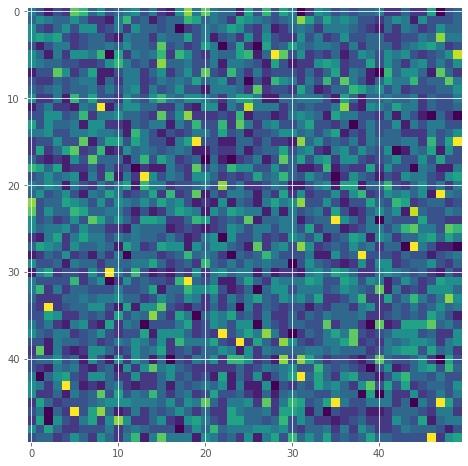

In [23]:
showField()

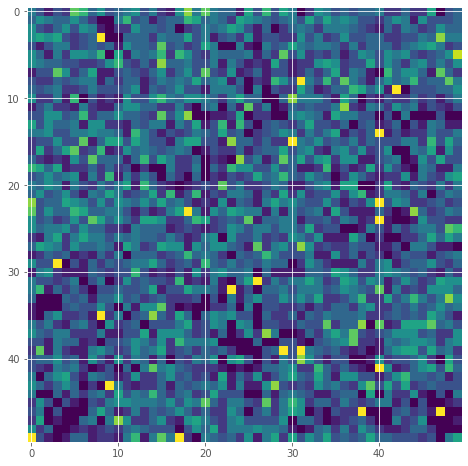

In [86]:
movePreds()
moveCarns()
showField()

In [144]:
r.hexists("tile:49:4","herbs2")

False

---

In [87]:
import json
import requests
import pymorphy2
import re
from bs4 import BeautifulSoup

In [88]:
# Функция для загрузки одной новости из Ленты.ру
def getLentaArticle(url):
    """ getLentaArticle gets the body of the article from Lenta.ru"""
    print("downloading lenta:", url)
    r = requests.get(url)
    p = BeautifulSoup(r.text, "html5")("p")
    if len(p) == 0:
        return "  "
    p = " ".join([a.get_text() for a in p])
    return p

# Функция загрузки одной новости из N+1.
def getArticleTextNPlus1(adr):
    print("downloading nplus1:", adr)
    r = requests.get(adr)
    n_text = re.split("</div>", re.split("</figure>", re.split('</article>',re.split('<article', r.text)[1])[0])[1])[1]    
    #return BeautifulSoup(n_text, "lxml").get_text()
    return BeautifulSoup(n_text, "html5").get_text()

# Загрузка новостей из Ленты.ру за некоторый период.
def getLenta():
    curdate = datetime.date(2017, 1, 16)
    findate = datetime.date(2017, 1, 16)
    res = ""
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)

# Загружаем новости до конечной даты.
    cnt = 0 # Очень скучно ждать, ограничим число новостей.
    while curdate <= findate:
        print('lenta ' + curdate.strftime('%Y/%m/%d'))
        day = requests.get('https://lenta.ru/news/' + curdate.strftime('%Y/%m/%d'))
        body = re.findall('<h3>(.+?)</h3>', day.text)
        links = ['https://lenta.ru' + re.findall('"(.+?)"', x)[0] for x in body]
        for l in links: # идем по всем ссылкам на новости за день.
            news = getLentaArticle(l)
            if news != "  ":
                redi.rpush("downloaded news", news)
            time.sleep(0.2)
            cnt += 1
            if cnt > 10:
                break
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("lenta finished")

# Получаем новости с NPlus1 за заданный промежуток времени, кладем тексты новостей в очередь qu.
# По завершении взводим семафор sem.
def getNplus1():
    curdate = datetime.date(2015, 12, 15)
    findate = datetime.date(2015, 12, 19)
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)
    cnt = 0
    while curdate <= findate: # Перебираем все дни.
        r = requests.get('https://nplus1.ru/news/'+curdate.strftime('%Y/%m/%d'))
        print('nplus ' + curdate.strftime('%Y/%m/%d'))
        # Берем заголовки и ссылки на новости за этот день.
        refs = [re.split('"', t)[6] for t in re.split('<article class="item item-news item-news', r.text)[1:]]
        for t in refs:
            news = getArticleTextNPlus1("https://nplus1.ru" + t)
            if news != "  ":
                redi.rpush("downloaded news", news)
            time.sleep(0.2) # Мы этичные хакеры и не стремимся к DDoS.
            cnt += 1
            if cnt > 10:
                break
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("nplus1 finished")
    
# Функция токенизирует вход из очереди qu1 и кладет результаты токенизации в очередь qu2.
# Токенизация ведется до тех пор, пока семафор semw не будет взведен максимальное количество раз.
# По завершении токенизации устанавливаем событие evs.
def tokenize():  
    redi = redis.Redis()
    redi.incrby("tokenizers", 1)
    
    c = 0
    while True: 
        news = redi.blpop("downloaded news", 1)
        if news == None:
            nd = redi.get("downloaders")
            if int(nd) == 0:
                break
            else:
                continue
                
        c += 1
        print('tokenizer ' + str(c))
        res = [n[0] for n in re.findall("([А-Яа-я]+(-[А-Яа-я]+)*)", news[1].decode())]
        news = redi.rpush("tagged news", json.dumps(res))
        
    redi.incrby("tokenizers", -1)
    print("tokenization finished")

def lemmatize():
    redi = redis.Redis()
    redi.incrby("lemmatizers", 1)

    morpho = pymorphy2.MorphAnalyzer() # Создаем морфоанализатор.
    l = []
    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("tagged news", 1)
        if news == None:
            nd = redi.get("tokenizers")
            if int(nd) == 0:
                break
            else:
                continue

        # blpop возвращает пару: имя списка, значение.
        txt = json.loads(news[1].decode())
        s = []
        for w in txt:
            s += morpho.parse(w)[0]
            
        res = json.dumps(str(s))
        redi.rpush("lemmatized news", res)
        c += 1
        print('lemma', c)
    redi.incrby("lemmatizers", -1)
    print("lemmatization finished")

# Функция имитирует, что она обрабатывает данные из очереди qu. Заершает работу по событию ev.    
def utilize():
    redi = redis.Redis()

    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("lemmatized news", 1)
        if news == None:
            nd = redi.get("lemmatizers")
            if int(nd) == 0:
                break
            else:
                continue
                
        #processing
        c += 1
        print('process', c)
    print('processing finished')


In [91]:
r = redis.Redis()
r.keys()

[]

In [90]:
r.flushdb()

True

In [92]:
lentap = multiprocessing.Process(target=getLenta)
nplusp = multiprocessing.Process(target=getNplus1)  
tokenp = multiprocessing.Process(target=tokenize)   
lemmap = multiprocessing.Process(target=lemmatize)   
processp = multiprocessing.Process(target=utilize)    


# Стартуем процессы    
lentap.start()
nplusp.start()
time.sleep(0.1)
tokenp.start()
time.sleep(0.1)
lemmap.start()
time.sleep(0.1)
processp.start()

# Если надо - ждем пока процессы не завершатся.
#lentap.join()
#nplusp.join()
#tokenp.join()
#lemmap.join()
#processp.join()
#print("Everything is allright")                               
                               

lenta 2017/01/16
nplus 2015/12/15
downloading nplus1: https://nplus1.ru/news/2015/12/15/tastelikehumanist
tokenizer 1
process 1
lemma 1
downloading nplus1: https://nplus1.ru/news/2015/12/15/soyuz-19m-success
tokenizer 2
process 2
lemma 2
downloading nplus1: https://nplus1.ru/news/2015/12/15/new-particle
tokenizer 3
lemma 3
process 3
downloading nplus1: https://nplus1.ru/news/2015/12/15/ocean-xprize
tokenizer 4
process 4
lemma 4
downloading nplus1: https://nplus1.ru/news/2015/12/15/amegilla
tokenizer 5
process 5
lemma 5
downloading nplus1: https://nplus1.ru/news/2015/12/15/veggie
tokenizer 6
lemma 6
process 6
downloading nplus1: https://nplus1.ru/news/2015/12/15/saar
tokenizer 7
process 7
lemma 7
downloading lenta: https://lenta.ru/news/2017/01/16/apollo/
downloading nplus1: https://nplus1.ru/news/2015/12/15/lemurvocalisation
tokenizer 8
process 8
lemma 8
downloading nplus1: https://nplus1.ru/news/2015/12/15/engine
tokenizer 9
process 9
lemma 9
tokenizer 10
lemma 10
process 10
downloadi

In [93]:
print(r.get('downloaders'), r.get('tokenizers'), r.get('lemmatizers'))
print(r.blpop("downloaded news", 1))

b'0' b'0' b'0'
None
